In [1]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import FuncFormatter
%config InlineBackend.figure_format='retina'

In [3]:
pd.set_option('display.max_rows',100)

## Predict_date is one of input

In [36]:
predict_date='2018_11_1'

## find 30 previous days and not cross over 2 months and not over year

In [37]:
num_day=30

In [38]:
predict_day=int(predict_date[8:])
predict_month=int(predict_date[5:7])
predict_year=int(predict_date[0:4])

In [39]:
str(predict_year)+'_'+str(predict_month)+'_'+str(predict_day)

'2018_11_1'

In [40]:
daybefore=[]
pmb=predict_month-1
dayleft=num_day-predict_day

In [41]:
if predict_day>=num_day:
    day=predict_day-num_day
    while day<predict_day:
        daybefore.append(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(day).zfill(2))
        day+=1
else:
    if pmb==1 or pmb==3 or pmb==5 or pmb==7 or pmb==8 or pmb==10 or pmb==12:
        for i in range(31-dayleft,32,1):
            daybefore.append(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(i).zfill(2))
        for i in range(1,predict_day,1):
            daybefore.append(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(i).zfill(2))
    elif pmb==4 or pmb==6 or pmb==9 or pmb==11:
        for i in range(30-dayleft,31,1):
            daybefore.append(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(i).zfill(2))
        for i in range(1,predict_day,1):
            daybefore.append(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(i).zfill(2))
    else:
        if predict_year%4==0:
            for i in range(29-dayleft,30,1):
                daybefore.append(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(i).zfill(2))
            for i in range(1,predict_day,1):
                daybefore.append(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(i).zfill(2))
        else:
            for i in range(28-dayleft,29,1):
                daybefore.append(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(i).zfill(2))
            for i in range(1,predict_day,1):
                daybefore.append(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(i).zfill(2))
    
    

In [42]:
daybefore

['2018_10_02',
 '2018_10_03',
 '2018_10_04',
 '2018_10_05',
 '2018_10_06',
 '2018_10_07',
 '2018_10_08',
 '2018_10_09',
 '2018_10_10',
 '2018_10_11',
 '2018_10_12',
 '2018_10_13',
 '2018_10_14',
 '2018_10_15',
 '2018_10_16',
 '2018_10_17',
 '2018_10_18',
 '2018_10_19',
 '2018_10_20',
 '2018_10_21',
 '2018_10_22',
 '2018_10_23',
 '2018_10_24',
 '2018_10_25',
 '2018_10_26',
 '2018_10_27',
 '2018_10_28',
 '2018_10_29',
 '2018_10_30',
 '2018_10_31']

## Have daybefore

In [43]:
pathlist=[]
for i in daybefore:
    pathlist.append('Energy_Balance_'+str(i))
pathlist

['Energy_Balance_2018_10_02',
 'Energy_Balance_2018_10_03',
 'Energy_Balance_2018_10_04',
 'Energy_Balance_2018_10_05',
 'Energy_Balance_2018_10_06',
 'Energy_Balance_2018_10_07',
 'Energy_Balance_2018_10_08',
 'Energy_Balance_2018_10_09',
 'Energy_Balance_2018_10_10',
 'Energy_Balance_2018_10_11',
 'Energy_Balance_2018_10_12',
 'Energy_Balance_2018_10_13',
 'Energy_Balance_2018_10_14',
 'Energy_Balance_2018_10_15',
 'Energy_Balance_2018_10_16',
 'Energy_Balance_2018_10_17',
 'Energy_Balance_2018_10_18',
 'Energy_Balance_2018_10_19',
 'Energy_Balance_2018_10_20',
 'Energy_Balance_2018_10_21',
 'Energy_Balance_2018_10_22',
 'Energy_Balance_2018_10_23',
 'Energy_Balance_2018_10_24',
 'Energy_Balance_2018_10_25',
 'Energy_Balance_2018_10_26',
 'Energy_Balance_2018_10_27',
 'Energy_Balance_2018_10_28',
 'Energy_Balance_2018_10_29',
 'Energy_Balance_2018_10_30',
 'Energy_Balance_2018_10_31']

In [44]:
def clean(path):
    rawdata=pd.read_csv(path+".csv", delimiter=";" )
    deleteindex=rawdata.loc[rawdata.loc[pd.IndexSlice[:,'Battery discharging / Mean values [W] ']]==' '].index
    rawdata.drop(deleteindex,inplace=True)
    rawdata.rename(columns={' ':'Time'},inplace=True)
    rawdata['Time']=rawdata['Time'].str.replace('[^\d]','')
    rawdata['Time']=path[15:19]+path[20:22]+path[23:]+rawdata['Time']
    rawdata['Time']=pd.to_datetime(rawdata.Time)
    rawdata.set_index('Time', inplace=True)
    for i in rawdata.columns:
        if i != 'Direct consumption / Mean values [W] ' and i != 'Battery discharging / Mean values [W] ' and i!='External energy supply / Mean values [W] ' and i != 'PV power generation / Mean values [W]  ':
            rawdata.drop([i],axis=1,inplace=True)
    for i in rawdata.columns:
        rawdata[i].fillna('0',inplace=True)
        rawdata[i]=rawdata[i].apply(lambda x: x.replace(' ', '0'))
        rawdata[i]=rawdata[i].str.replace('\D','').astype(int)
    rawdata['Consumption']=rawdata['Direct consumption / Mean values [W] ']+rawdata['Battery discharging / Mean values [W] ']+rawdata['External energy supply / Mean values [W] ']
    rawdata.rename(columns={'PV power generation / Mean values [W]  ':'Generation'},inplace=True)
    rawdata.drop(['Direct consumption / Mean values [W] ', 'Battery discharging / Mean values [W] ','External energy supply / Mean values [W] '],axis=1,inplace=True)
    rawdata.drop(['Generation'],axis=1,inplace=True)
    return rawdata

In [45]:
rawdata=[]

In [46]:
for i in pathlist:
    df=clean(i)
    rawdata.append(df)
rawdata
    

[                     Consumption
 Time                            
 2018-10-02 00:15:00         1975
 2018-10-02 00:30:00         1641
 2018-10-02 00:45:00         1857
 2018-10-02 01:00:00         2129
 2018-10-02 01:15:00         1168
 2018-10-02 01:30:00         1246
 2018-10-02 01:45:00         1300
 2018-10-02 02:00:00         1777
 2018-10-02 02:15:00         1651
 2018-10-02 02:30:00         1072
 2018-10-02 02:45:00          875
 2018-10-02 03:00:00         1646
 2018-10-02 03:15:00         1481
 2018-10-02 03:30:00         1324
 2018-10-02 03:45:00         1018
 2018-10-02 04:00:00          892
 2018-10-02 04:15:00         1510
 2018-10-02 04:30:00         1365
 2018-10-02 04:45:00         1628
 2018-10-02 05:00:00         1642
 2018-10-02 05:15:00         2348
 2018-10-02 05:30:00         2422
 2018-10-02 05:45:00         1896
 2018-10-02 06:00:00         1234
 2018-10-02 06:15:00         1070
 2018-10-02 06:30:00         2152
 2018-10-02 06:45:00         1115
 2018-10-02 07

In [47]:
data=rawdata[0]
for i in range(num_day-1):
    data=pd.concat([data,rawdata[i+1]])
data.shape


(2880, 1)

In [48]:
data

,Consumption
Time,
2018-10-02 00:15:00,1975
2018-10-02 00:30:00,1641
2018-10-02 00:45:00,1857
2018-10-02 01:00:00,2129
2018-10-02 01:15:00,1168
2018-10-02 01:30:00,1246
2018-10-02 01:45:00,1300
2018-10-02 02:00:00,1777
2018-10-02 02:15:00,1651


## Complete the missing value with value in day before

In [49]:
(data.Consumption==0).any()

True

In [50]:
for i in range(data.shape[0]):
    if data.iloc[i,0]==0:
        data.iloc[i,0]=data.iloc[i-96,0]
        print(data.iloc[i])

Consumption    1987
Name: 2018-10-18 02:30:00, dtype: int32
Consumption    1862
Name: 2018-10-18 02:45:00, dtype: int32
Consumption    2098
Name: 2018-10-18 03:00:00, dtype: int32
Consumption    1918
Name: 2018-10-18 03:15:00, dtype: int32
Consumption    771
Name: 2018-10-21 09:30:00, dtype: int32
Consumption    812
Name: 2018-10-21 09:45:00, dtype: int32
Consumption    970
Name: 2018-10-21 10:00:00, dtype: int32
Consumption    798
Name: 2018-10-21 10:15:00, dtype: int32
Consumption    913
Name: 2018-10-21 10:30:00, dtype: int32
Consumption    794
Name: 2018-10-21 10:45:00, dtype: int32
Consumption    778
Name: 2018-10-21 11:00:00, dtype: int32
Consumption    1025
Name: 2018-10-21 11:15:00, dtype: int32
Consumption    1214
Name: 2018-10-21 11:30:00, dtype: int32
Consumption    1311
Name: 2018-10-21 11:45:00, dtype: int32
Consumption    1707
Name: 2018-10-21 12:00:00, dtype: int32
Consumption    1494
Name: 2018-10-21 12:15:00, dtype: int32
Consumption    2264
Name: 2018-10-21 12:30:00, 

In [51]:
fit4 = ExponentialSmoothing(data.Consumption, seasonal_periods=96, trend='add' ,seasonal='mul').fit()

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [52]:
fit4

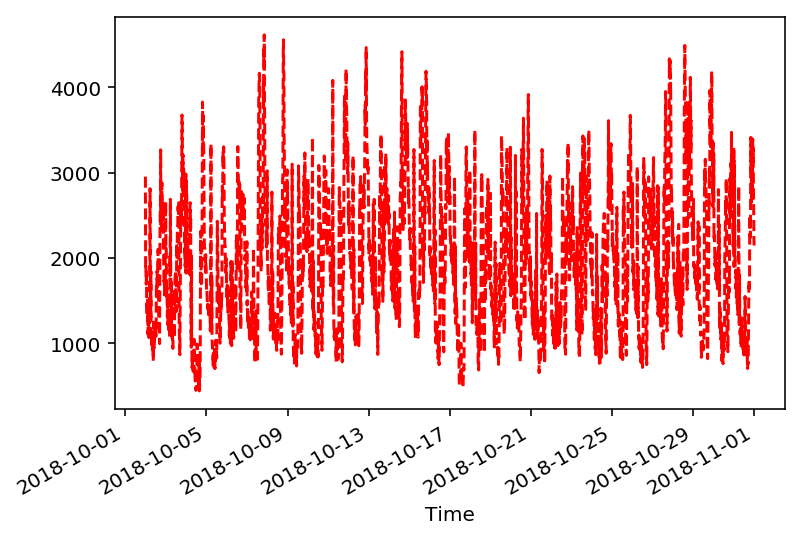

In [53]:
fit4.fittedvalues.plot(style='--', color='red')

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


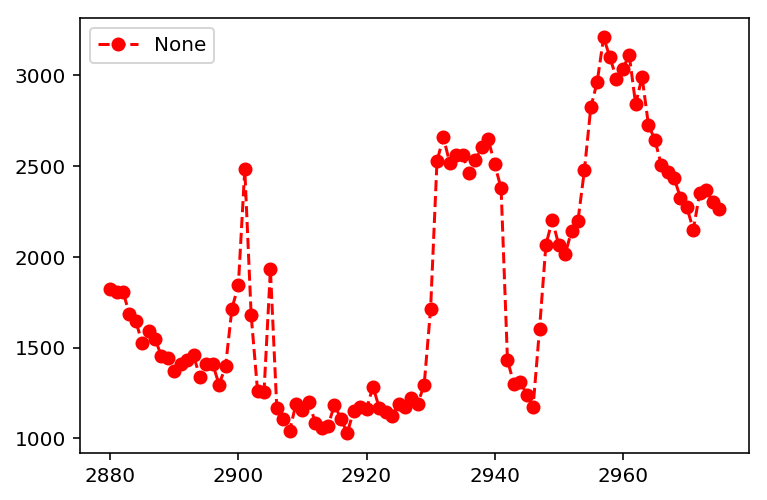

In [54]:
forecast=fit4.forecast(96)
forecast.plot(style='--', marker='o', color='red', legend=True)

In [55]:
compare=clean('Energy_Balance_'+predict_date)
compare

FileNotFoundError: File b'Energy_Balance_2018_11_1.csv' does not exist

In [ ]:
pmb=predict_month-1
if predict_day>1:
        db=(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(predict_day-1).zfill(2))
else:
    if pmb==1 or pmb==3 or pmb==5 or pmb==7 or pmb==8 or pmb==10 or pmb==12:
        db=(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(31).zfill(2))
    elif pmb==4 or pmb==6 or pmb==9 or pmb==11:
        db=(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(30).zfill(2))
    else:
        if predict_year%4==0:
            db=(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(29).zfill(2))
        else:
            db=(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(38).zfill(2))    
dayb=clean('Energy_Balance_'+db)
bf=clean('Energy_Balance_'+str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(predict_day-1).zfill(2))
for i in range(compare.shape[0]):
    if compare.iloc[i,0]==0:
        compare.iloc[i,0]=dayb.iloc[i,0]

In [ ]:
forecastcolumn=[]
for i in range(96):
    forecastcolumn.append(forecast.iloc[i])

In [ ]:
compare['Forecast']=forecastcolumn

In [ ]:
compare.rename(columns={'Consumption':'Real'},inplace=True)

In [ ]:
compare

## Get missing info 13/12 9:15 =1000

In [ ]:
compare['Error']=compare['Real']-compare['Forecast']

In [ ]:
compare['absError/Real']=abs(compare['Error'])/compare['Real']

In [ ]:
compare

In [ ]:
MAPE=compare['absError/Real'].sum()*100/96
MAPE

In [ ]:
compare[['Real','Forecast']].plot(kind='line')

In [ ]:
abs(compare.Error).plot(kind='line')

In [ ]:
fit4.model.params